## Model for damage (amount)
- do a better model for predicting binary data
- take care only for those who are predicted to be 


In [1]:
import numpy as np
import pandas as pd
import getpass
from pathlib import Path

from sklearn.model_selection import train_test_split


In [2]:

  
def read_pkl(train_name, score_name,  project_root_path = "/home/daniel/Projects/Python ML Pipeline"):
    if getpass.getuser() == 'daniel':
        project_root_path = Path(project_root_path)
        pkl_path = project_root_path / 'data' /'processed'
        # Lets read the trining dataset
        data = pd.read_pickle(pkl_path/  train_name)
        # Now we read the training data set
        score = pd.read_pickle(pkl_path /  score_name)
    return (data,score)

In [3]:
  
data_dict = {'train_name': 'data_train_v3.pkl', 'score_name': 'score_v3.pkl'}
data_train, score = read_pkl(**data_dict)

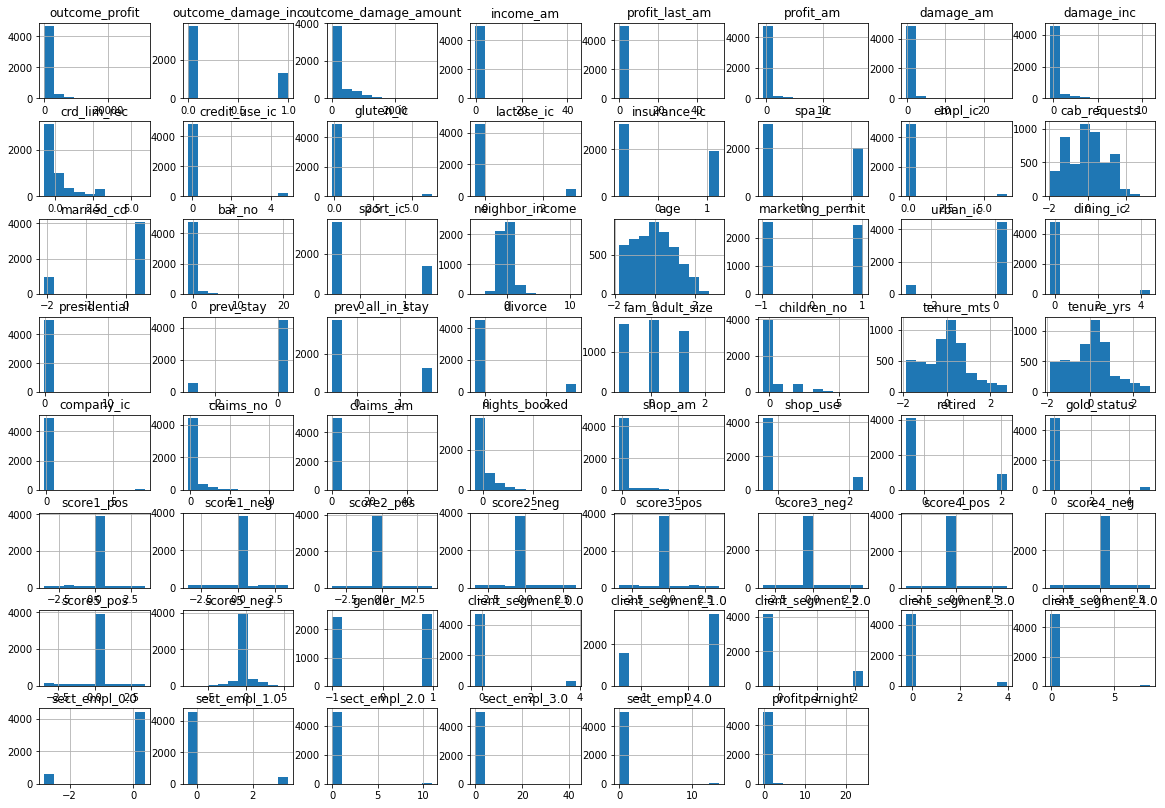

In [4]:
_ = data_train.hist(figsize=(20, 14))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_inc'], test_size=0.2, random_state=48)
data_train.outcome_damage_inc.value_counts()

0    3723
1    1277
Name: outcome_damage_inc, dtype: int64

preprocessing.LabelEncoder() - convert string or float values to 0 .. n classes.

If we put as imput X_train, y_train to fit method it cause error. To avoid it we will convert and encode labels.

In [6]:
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y_train)
# this seems to be unnecessary

In [7]:
y_train.head()

1235    0
414     0
1564    0
862     1
3048    0
Name: outcome_damage_inc, dtype: int64

In [8]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}
gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train, y_train)
gbm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'subsample': 0.6,
 'n_estimators': 669,
 'min_samples_split': 30,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 2,
 'learning_rate': 0.012542015897895777}

In [9]:
params = gbm_random.best_params_
gbm_damagebin = GradientBoostingClassifier(**params)
gbm_damagebin.fit(X_train, y_train)
print('Train accuracy: %.3f' % gbm_damagebin.score(X_train, y_train))
print('Test accuracy: %.3f' % gbm_damagebin.score(X_test, y_test))

Train accuracy: 0.767
Test accuracy: 0.767


In [10]:
damagebin_preds = gbm_damagebin.predict_proba(score)

# Model for damage (amount)


In [11]:
from sklearn.model_selection import train_test_split
data_dam = data_train[data_train.outcome_damage_inc == 1]
data_dam.shape

(1277, 62)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_dam.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1), 
                                                    data_dam['outcome_damage_amount'], test_size=0.2, random_state=29949)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train, y_train)
gbm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'subsample': 0.4,
 'n_estimators': 412,
 'min_samples_split': 5,
 'min_samples_leaf': 30,
 'max_features': 'auto',
 'max_depth': 8,
 'learning_rate': 0.009469488710361799}

In [13]:
params = gbm_random.best_params_
gbm_damageam = GradientBoostingRegressor(**params)
gbm_damageam.fit(X_train, y_train)
print('R2: %.3f' % gbm_damageam.score(X_train, np.array(y_train).reshape(-1,1)))
print('R2: %.3f' % gbm_damageam.score(X_test, np.array(y_test).reshape(-1,1)))
damageam_preds = gbm_damageam.predict(score)

R2: 0.390
R2: 0.112


# Answering the last question

In [24]:
data_output_path = "/home/daniel/Projects/Python ML Pipeline/data/processed/"
path = data_output_path + "profit_preds_v3.pkl.npy"


In [ ]:
profit_preds = np.load(path)
pred_all = pd.Series(profit_preds - [x[1] for x in damagebin_preds] * damageam_preds)
pred_allexp_profit = pd.Series(profit_preds - [x[1] for x in damagebin_preds] * damageam_preds)
exp_profit.index = score.index
score['exp_profit'] = exp_profit

<AxesSubplot:>

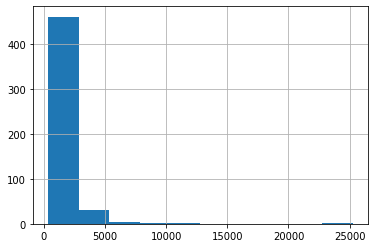

In [17]:
pred_all.hist()

In [19]:
exp_profit = pd.Series(profit_preds - [x[1] for x in damagebin_preds] * damageam_preds)
exp_profit.index = score.index
score['exp_profit'] = exp_profit

In [26]:
score.sort_values('exp_profit', ascending=False).head(10)
score.to_pickle(data_output_path + "score_semi_final.pkl")
